Це програма, що класифікує текст на зображенні на печатний чи рукописний за допомогою Згорткової Нейронної Мережі (DNN)

In [36]:
import numpy as np
import os
from scipy import misc
import matplotlib.pyplot as plt
from functools import reduce
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Клас для зручної роботи із сетом зображень
class ImageSet:
    # конструювання
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels
        self.set_size = filenames.size
        self.to_return = 0
        
    def _next_batch_filenames(self, batch_size):
        if batch_size > self.set_size:
            raise Exception("Batch size is {}, set size is {}".format(batch_size, self.set_size))
        if self.to_return + batch_size > self.set_size:
            remains = batch_size - (self.set_size - self.to_return)
            batch_filenames = np.concatenate([self.filenames[self.to_return:], self.filenames[:remains]])
            batch_labels = np.concatenate([self.labels[self.to_return:], self.labels[:remains]])
            self.to_return = remains
        else:
            batch_filenames = self.filenames[self.to_return: self.to_return + batch_size]
            batch_labels = self.labels[self.to_return: self.to_return + batch_size]
            self.to_return += batch_size
        if self.to_return == self.set_size:
            self.to_return = 0
        return batch_filenames, batch_labels
    
    # Наступний патч зображень заданого розміру
    def next_batch(self, batch_size):
        filenames, labels = self._next_batch_filenames(batch_size)
        images = []
        for filename in filenames:
            img = misc.imread(rootdir + filename, mode = 'F').astype(np.float)
            img = img.flatten()
            img /= 255.
            images.append(img)
        return np.array(images), labels
    
    # Повертає патч з усіз зображень
    def whole_set(self):
        return self.next_batch(self.set_size)

In [3]:
# Шлях до папки, де лежать усі зображення
rootdir = 'resized_data'

In [4]:
# Будемо працювати з першими 12000 зображеннями 
set_size = 12000
# Загружаємо печатні зображення у пам'ять
hw_filenames = np.array(['/HW/' + name for name in os.listdir(rootdir + '/HW')[:set_size]])
# Загружаємо рукописні зображення у пам'ять
mp_filenames = np.array(['/MP/' + name for name in os.listdir(rootdir + '/MP')[:set_size]])
hw_label = np.array([1,0])
hw_labels = np.tile(hw_label, (set_size, 1))
mp_label = np.array([0,1])
mp_labels = np.tile(mp_label, (set_size, 1))
print(hw_labels.shape)
print(mp_labels.shape)
# Мітки у вигляді
# (1,0) - печатний текст
# (0,1) - рукописний текст

(12000, 2)
(12000, 2)


In [5]:
filenames = np.concatenate((hw_filenames, mp_filenames))
labels = np.concatenate((hw_labels, mp_labels))

Розділяємо сет на (train, validation, test) за допомогою функції train_test_split (вона також перемішує сет)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.3, random_state=42)

In [7]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.3333, random_state=42)

In [8]:
train_set = ImageSet(X_train, y_train)
valid_set = ImageSet(X_valid, y_valid)
test_set = ImageSet(X_test, y_test)

In [9]:
print("Train set size: {}".format(train_set.set_size))
print("Validation set size: {}".format(valid_set.set_size))
print("Test set size: {}".format(test_set.set_size))

Train set size: 16800
Validation set size: 4800
Test set size: 2400


Починаємо конструювання нейронної мережі. На вхід вона приймає зображення у відтінках сірого розміром 30\*60 (усі зображення було попередньо оброблено). 
Структура нейронної мережі:
 * 32 фільтри розміром 5\*5
 * ReLU-шар
 * Max-pooling шар
 * 4 фільтри розміром 5\*5
 * ReLU-шар
 * Max-pooling шар
 * Повнозв'язний шар
 * ReLU-шар
 * Drop-Out шар
 * Повнозв'язний шар 

In [10]:
width = 30
height = 60
flat = width * height
out_classes = 2

In [11]:
input_images = tf.placeholder(tf.float32, shape=[None, flat])
# only two possibilities (hw or mp)
input_labels = tf.placeholder(tf.float32, shape=[None, out_classes])
input_images

<tf.Tensor 'Placeholder:0' shape=(?, 1800) dtype=float32>

In [12]:
avg_size = (width, height)
reshaped_images = tf.reshape(input_images, [-1, width, height, 1])
reshaped_images

<tf.Tensor 'Reshape:0' shape=(?, 30, 60, 1) dtype=float32>

In [13]:
filters_num1 = 32
width1 = int((width + 1)/ 2)
height1 = int((height + 1)/ 2)
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, filters_num1], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[filters_num1]))

In [14]:
convolve1 = tf.nn.conv2d(reshaped_images, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1

In [15]:
h_conv1 = tf.nn.relu(convolve1)

In [16]:
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 15, 30, 32) dtype=float32>

In [17]:
filters_num2 = 4 * filters_num1
width2 = int((width1 + 1)/ 2 )
height2 = int((height1 + 1)/ 2)
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, filters_num1, filters_num2], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[filters_num2])) #need 128 biases for 128 outputs

In [18]:
convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2

In [19]:
h_conv2 = tf.nn.relu(convolve2)

In [20]:
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 15, 128) dtype=float32>

In [21]:
layer2_matrix = tf.reshape(conv2, [-1, width2*height2*filters_num2])

In [22]:
fully_num1 = 1024
W_fc1 = tf.Variable(tf.truncated_normal([width2*height2*filters_num2, fully_num1], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[fully_num1])) # need 1024 biases for 1024 outputs

In [23]:
fcl=tf.matmul(layer2_matrix, W_fc1) + b_fc1

In [24]:
h_fc1 = tf.nn.relu(fcl)
h_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

In [25]:
keep_prob = tf.placeholder(tf.float32)
layer_drop = tf.nn.dropout(h_fc1, keep_prob)
layer_drop

<tf.Tensor 'dropout/mul:0' shape=(?, 1024) dtype=float32>

In [26]:
W_fc2 = tf.Variable(tf.truncated_normal([fully_num1, out_classes], stddev=0.1)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[out_classes])) # 2 possibilities for hw or mp

In [27]:
fc=tf.matmul(layer_drop, W_fc2) + b_fc2

In [28]:
labels_CNN= tf.nn.softmax(fc)
labels_CNN

<tf.Tensor 'Softmax:0' shape=(?, 2) dtype=float32>

In [29]:
correct_prediction = tf.equal(tf.argmax(labels_CNN,1), tf.argmax(input_labels,1))

In [30]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Ця частина була потрібна для тренування та валідації мережі. Зараз не використовується, оскільки я вже відкриваю натреновану модель із жорсткого диску.

In [29]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(input_labels * tf.log(labels_CNN), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [ ]:
sess= tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# Тренуємо патчами по 50 зображень
# Для тренування пропустимо усесь сет зображень 30 разів
batch_size = 50
epoch_num = 30
batches_in_epoch = train_set.set_size // batch_size

In [142]:
sess= tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [141]:
sess.close()

In [134]:
batch_size = 50
epoch_num = 30
batches_in_epoch = train_set.set_size // batch_size

In [130]:
def validate_network():
    batch_images, batch_labels = valid_set.whole_set()
    train_accuracy = accuracy.eval(feed_dict={input_images:batch_images, input_labels: batch_labels, keep_prob: 1.0})
    print("step %d, validation accuracy %g"%(i, float(train_accuracy)))

In [131]:
saver = tf.train.Saver()

In [137]:
def save_network(epoch_num):
    # Save variables to disk.
    save_path = saver.save(sess, "/Users/olya2/Python/Diplom/valid_model/epoch{}model2conv.ckpt".format(epoch_num))
    print("Model saved in path: %s" % save_path)

In [149]:
for i in range(batches_in_epoch * epoch_num):
    batch_images, batch_labels = train_set.next_batch(batch_size)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={input_images:batch_images, input_labels: batch_labels, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, float(train_accuracy)))
    if (i + 1) % batches_in_epoch == 0:
        validate_network()
        # Зберегаємо проміжні результати на диску
        save_network((i + 1) // batches_in_epoch)
    train_step.run(feed_dict={input_images:batch_images, input_labels: batch_labels, keep_prob: 0.5})

step 0, training accuracy 0.4
step 100, training accuracy 0.66
step 200, training accuracy 0.78
step 300, training accuracy 0.78
step 335, validation accuracy 0.823333
Model saved in path: /Users/olya2/Python/Diplom/valid_model/epoch1model2conv.ckpt
step 400, training accuracy 0.78
step 500, training accuracy 0.74
step 600, training accuracy 0.82
step 671, validation accuracy 0.833333
Model saved in path: /Users/olya2/Python/Diplom/valid_model/epoch2model2conv.ckpt
step 700, training accuracy 0.78
step 800, training accuracy 0.8
step 900, training accuracy 0.88
step 1000, training accuracy 0.94
step 1007, validation accuracy 0.83625
Model saved in path: /Users/olya2/Python/Diplom/valid_model/epoch3model2conv.ckpt
step 1100, training accuracy 0.84
step 1200, training accuracy 0.76
step 1300, training accuracy 0.88
step 1343, validation accuracy 0.84375
Model saved in path: /Users/olya2/Python/Diplom/valid_model/epoch4model2conv.ckpt
step 1400, training accuracy 0.84
step 1500, training 

In [31]:
saver = tf.train.Saver()

In [32]:
sess = tf.InteractiveSession()

In [33]:
# Restore variables from disk.
saver.restore(sess, "/Users/olya2/Python/Diplom/model2/model2conv.ckpt")
print("Model restored.")

INFO:tensorflow:Restoring parameters from /Users/olya2/Python/Diplom/model2/model2conv.ckpt
Model restored.


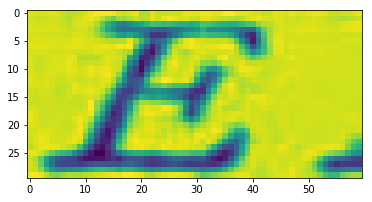

In [51]:
# Приклад зображення із сету
sampleimage = train_set.next_batch(1)[0]
plt.imshow(sampleimage.reshape(30, 60))

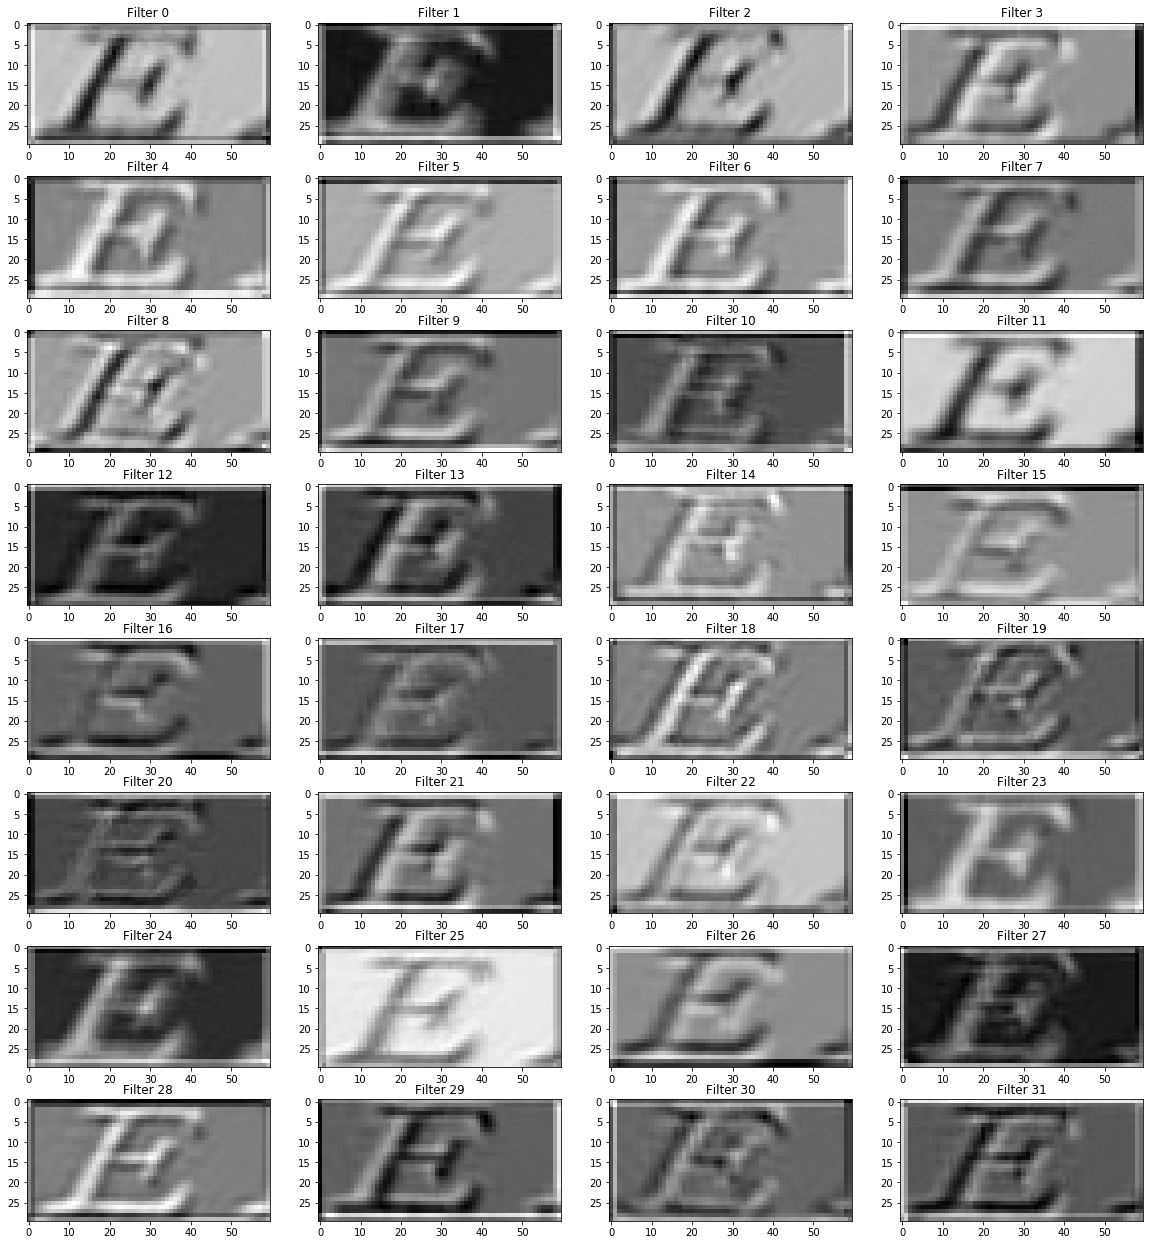

In [52]:
# Зображення після першого шару нейронної мережі (застосування 32ох фільтрів до зображення)
ActivatedUnits = sess.run(convolve1,feed_dict={input_images:np.reshape(sampleimage[0],[1,flat],order='F'),keep_prob:1.0})
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,25))
n_columns = 4
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

In [46]:
# Результат роботи нейронної мережі на тестовому сеті (дані, що нейромережа ще не бачила)
test_images, test_labels = test_set.whole_set()
print("Test accuracy %g"%accuracy.eval(feed_dict={input_images: test_images, input_labels: test_labels, keep_prob: 1.0}))

Test accuracy 0.9225
